# Compare and Calculate climatology and anomaly of ERA5/GOES/MERRA2 net shortwave and sst

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import json
import gcsfs
from scipy.signal import detrend

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

era = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/ERA5/datasets/gom_updated.zarr'))
merra = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/MERRA2/datasets/rad.zarr'))
goes_t = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/GOES/datasets/sw_ds.zarr'))

## Shortwave

In [2]:
## convert sw from J/m^2 -> W/m^2
sw_wm2 = era.ssr / (60*60)
#resample to daily freq (hourly too noisy
sw = sw_wm2.resample(time='D').mean('time')

In [3]:
goes = goes_t.assign_coords({'time':goes_t.t}).swap_dims({'t':'time'}).drop_vars('t')

In [4]:
sw_merra = merra.SWGNT.resample(time='D').mean('time')
sw_goes = goes.DSR.resample(time='D').mean('time')

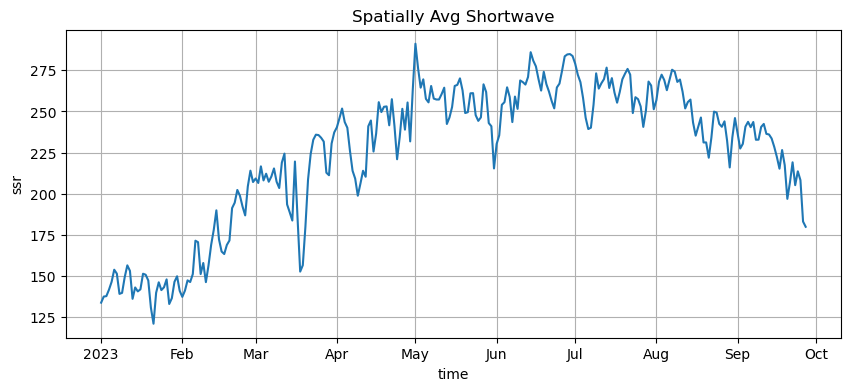

In [5]:
sw.mean(['latitude', 'longitude']).plot(figsize=(10,4))
plt.grid()
plt.title('Spatially Avg Shortwave');

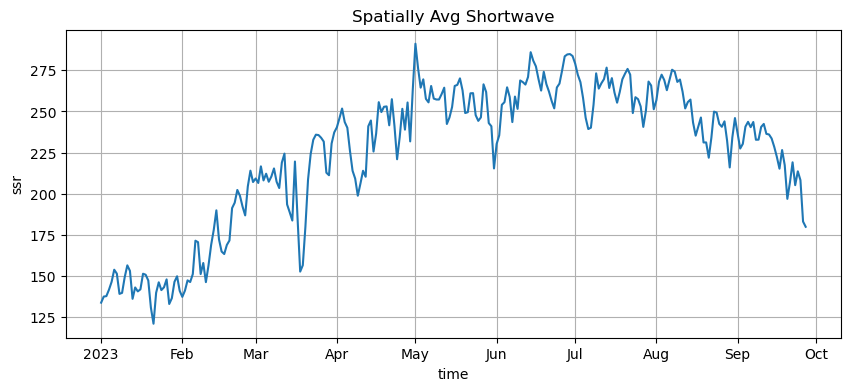

In [6]:
sw.sel(time=slice('2021', '2023-09-30')).mean(['latitude', 'longitude']).plot(figsize=(10,4))
plt.grid()
plt.title('Spatially Avg Shortwave');

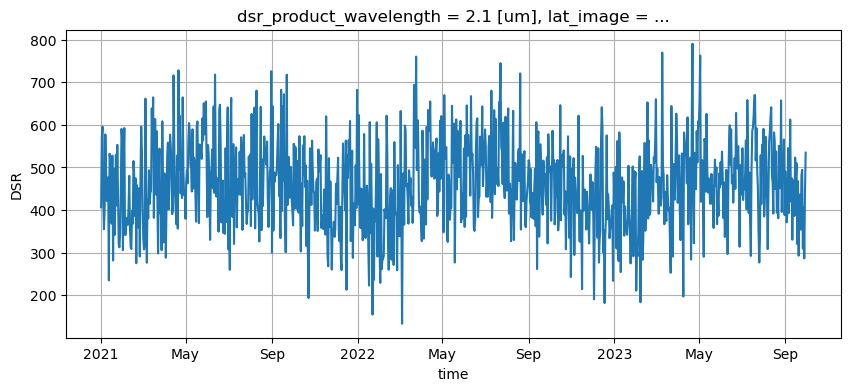

In [7]:
sw_goes.sel(time=slice('2021', '2023-09-30')).mean(['lat', 'lon']).plot(figsize=(10,4))
plt.grid();

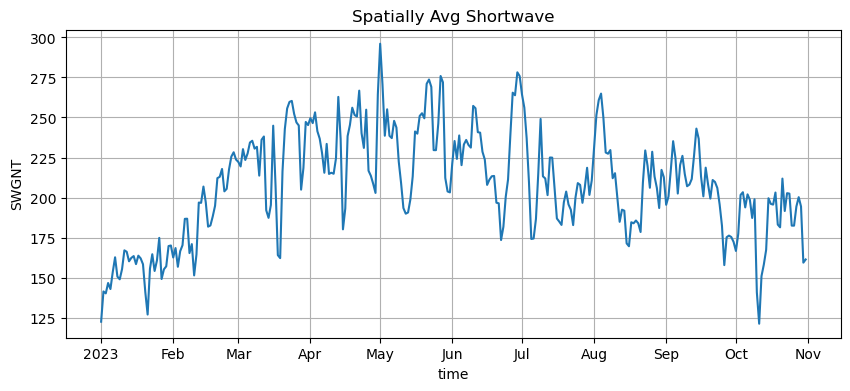

In [8]:
sw_merra.mean(['lat', 'lon']).plot(figsize=(10,4))
plt.grid()
plt.title('Spatially Avg Shortwave');

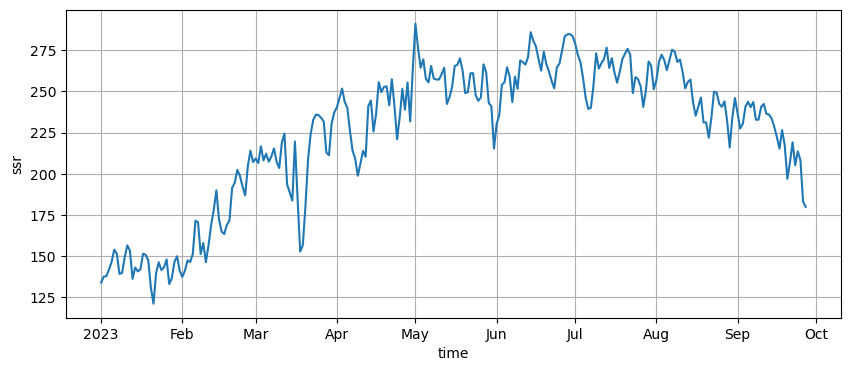

In [9]:
sw.mean(['latitude', 'longitude']).sel(time=slice('2023-01-01', '2023-11-01')).plot(figsize=(10,4))
plt.grid();

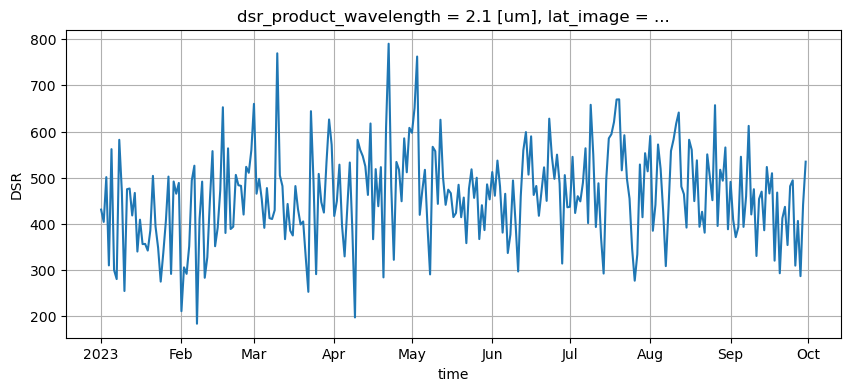

In [10]:
sw_goes.mean(['lat', 'lon']).sel(time=slice('2023-01-01', '2023-09-30')).plot(figsize=(10,4))
plt.grid();

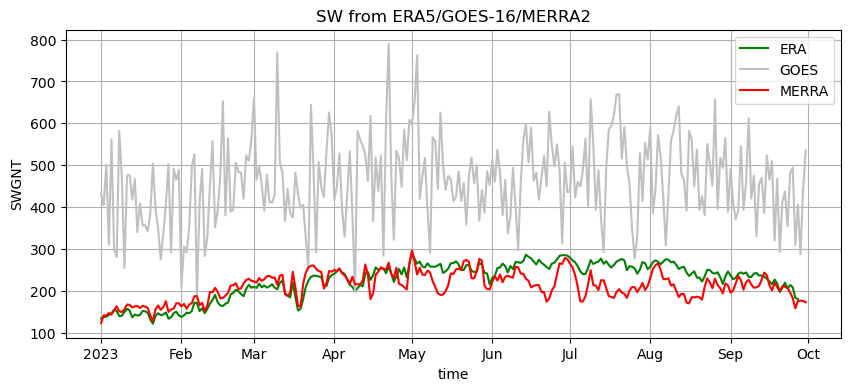

In [11]:
sw.sel(time=slice('2023-01-01', '2023-09-30')).mean(['latitude', 'longitude']).plot(figsize=(10,4), color='green', label='ERA')
sw_goes.sel(time=slice('2023-01-01', '2023-09-30')).mean(['lat', 'lon']).plot(color='silver', label='GOES')
sw_merra.sel(time=slice('2023-01-01', '2023-09-30')).mean(['lat', 'lon']).plot(color='red', label='MERRA')
plt.grid()
plt.legend()
plt.title('SW from ERA5/GOES-16/MERRA2');

In [37]:
sw_merra.load()

<xarray.DataArray 'SWGNT' (time: 304, lat: 19, lon: 45)>
array([[[184.20558 , 175.79688 , 165.82649 , ..., 185.09802 ,
         183.98108 , 183.48854 ],
        [179.72304 , 174.54036 , 164.70703 , ..., 177.6333  ,
         181.96245 , 181.068   ],
        [178.00293 , 173.35222 , 163.86491 , ..., 177.95825 ,
         180.59746 , 179.88676 ],
        ...,
        [137.44385 , 141.6408  , 140.78157 , ...,  64.7583  ,
          63.042797,  61.79909 ],
        [125.979576, 131.01514 , 132.77051 , ...,  56.87451 ,
          56.29428 ,  57.503178],
        [113.85702 , 117.15283 , 118.714195, ...,  46.00598 ,
          44.389637,  46.354427]],

       [[147.99945 , 158.67773 , 159.53352 , ..., 168.18486 ,
         167.30614 , 167.35547 ],
        [150.08604 , 156.75227 , 155.89095 , ..., 155.91504 ,
         155.06136 , 154.83119 ],
        [154.73177 , 156.7448  , 154.06055 , ..., 143.94972 ,
         143.84337 , 148.17255 ],
...
        [134.84572 , 135.79623 , 128.02734 , ..., 134.03291 ,
         153.15913 , 166.18884 ],
        [150.052   , 147.3225  , 138.53267 , ..., 132.18518 ,
         139.21082 , 146.201   ],
        [146.01912 , 147.06499 , 139.62787 , ..., 156.17534 ,
         142.00655 , 150.16597 ]],

       [[111.3691  ,  93.595055, 128.8108  , ...,  88.99227 ,
          84.528114, 111.17228 ],
        [101.01009 ,  93.83563 , 122.2456  , ..., 108.534424,
         103.53182 , 110.05367 ],
        [ 97.87842 , 119.810326, 161.31776 , ..., 116.704346,
         118.389244, 115.988   ],
        ...,
        [189.0046  , 186.83606 , 176.79189 , ..., 117.27466 ,
         133.32088 , 141.67004 ],
        [187.02026 , 187.30873 , 186.12392 , ...,  99.53003 ,
         117.65055 , 129.76262 ],
        [183.5761  , 184.24858 , 185.49469 , ...,  92.52189 ,
         105.29    , 122.79608 ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 22.0 22.5 23.0 23.5 24.0 ... 29.0 29.5 30.0 30.5 31.0
  * lon      (lon) float64 -100.0 -99.38 -98.75 -98.12 ... -73.75 -73.12 -72.5
  * time     (time) datetime64[ns] 2023-01-01 2023-01-02 ... 2023-10-31
Attributes:
    fmissing_value:  999999986991104.0
    long_name:       surface_net_downward_shortwave_flux
    standard_name:   surface_net_downward_shortwave_flux
    units:           W m-2
    vmax:            999999986991104.0
    vmin:            -999999986991104.0

In [67]:
mo_clim_sw = (sw).groupby('time.month').mean(['time', 'latitude', 'longitude'])
mo_anom_sw = (sw).groupby('time.month') - mo_clim_sw

#mo_clim_m = (sw_merra).groupby('time.month').mean(['time', 'latitude', 'longitude'])
#mo_anom_m = (sw_merra).groupby('time.month') - mo_clim_m

mo_clim_g = (sw_goes).groupby('time.month').mean(['time', 'lat', 'lon'])
mo_anom_g = (sw_goes).groupby('time.month') - mo_clim_g

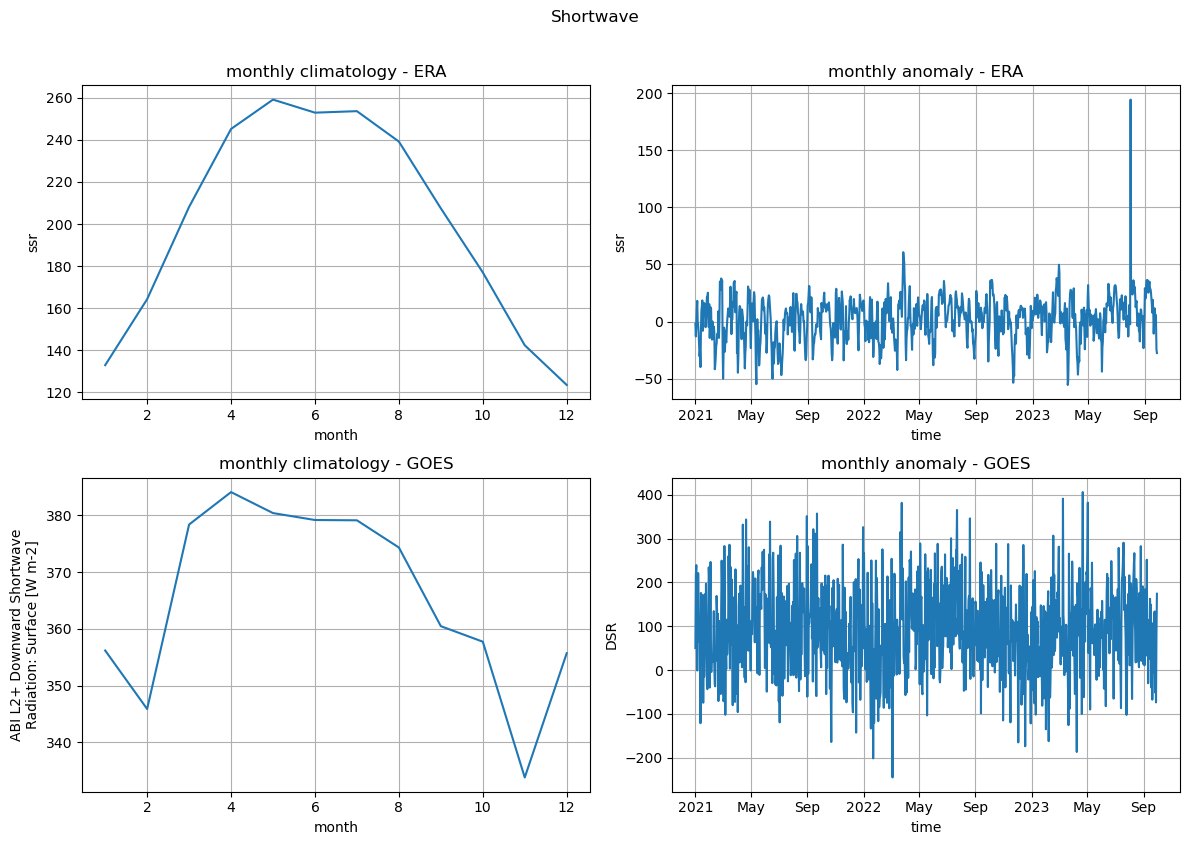

In [74]:
fig, ax = plt.subplots(2,2, figsize=(12,8))

mo_clim_sw.plot(ax=ax[0,0])
ax[0,0].set_title('monthly climatology - ERA')
ax[0,0].grid()
mo_anom_sw.sel(time=slice('2021', '2023-09-30')).mean(['latitude', 'longitude']).plot(ax=ax[0,1])
ax[0,1].set_title('monthly anomaly - ERA')
ax[0,1].grid()

mo_clim_g.plot(ax=ax[1,0])
ax[1,0].set_title('monthly climatology - GOES')
ax[1,0].grid()
mo_anom_g.sel(time=slice('2021', '2023-09-30')).mean(['lat', 'lon']).plot(ax=ax[1,1])
ax[1,1].set_title('monthly anomaly - GOES')
ax[1,1].grid()

plt.tight_layout()
plt.suptitle('Shortwave', y=1.05);

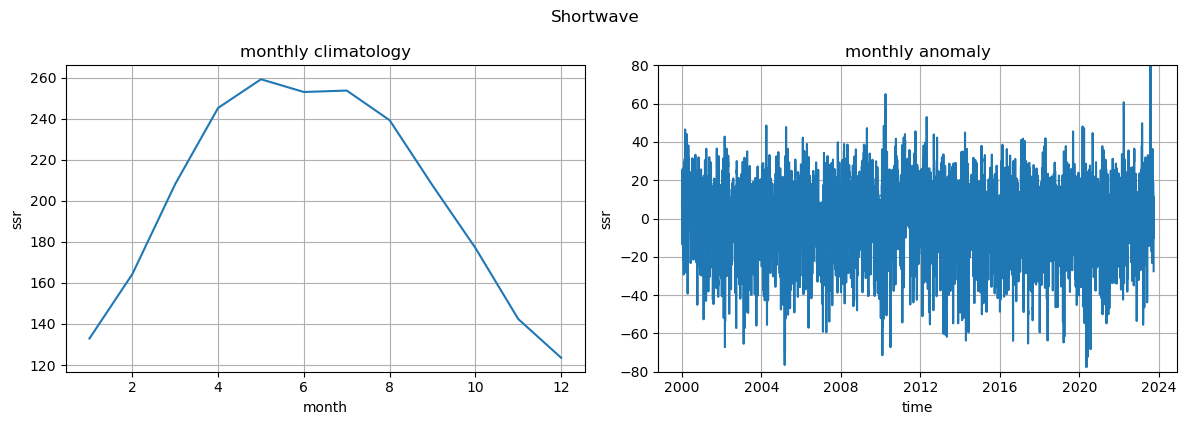

In [41]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

mo_clim_sw.plot(ax=ax0)
ax0.set_title('monthly climatology')
ax0.grid()
mo_anom_sw.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('monthly anomaly')
ax1.grid()
ax1.set_ylim(-80,80)
plt.tight_layout()
plt.suptitle('Shortwave', y=1.05);

In [8]:
yr_clim_sw = (sw).groupby('time.year').mean(['time', 'latitude', 'longitude'])
yr_anom_sw = (sw).groupby('time.year') - yr_clim_sw

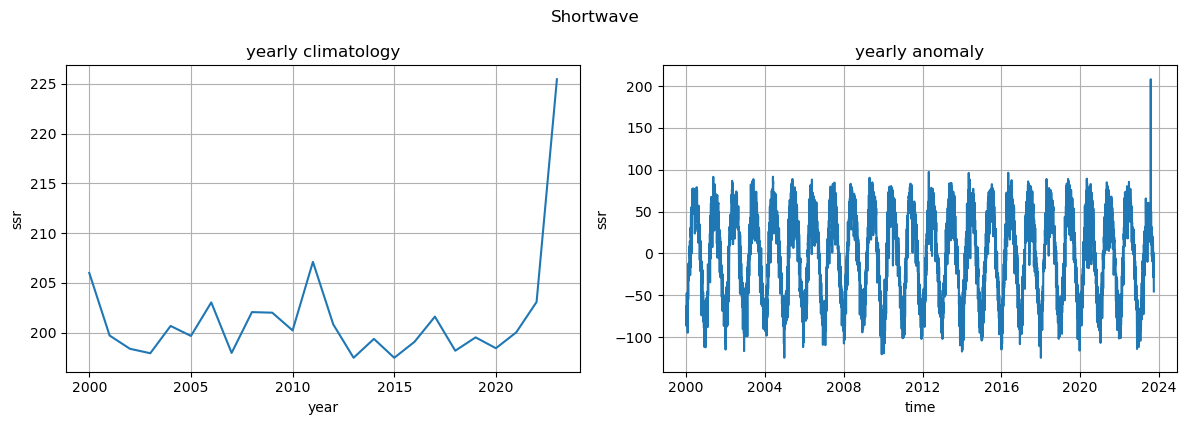

In [9]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

yr_clim_sw.plot(ax=ax0)
ax0.set_title('yearly climatology')
ax0.grid()
yr_anom_sw.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('yearly anomaly')
ax1.grid()
plt.tight_layout()
plt.suptitle('Shortwave', y=1.05);

## Detrended Shortwave

In [75]:
sw_detrend_e = xr.apply_ufunc(detrend, sw.fillna(0.).chunk({'time':-1}), kwargs=dict(axis=-1),
                                   input_core_dims=[['time']],
                                   output_core_dims=[['time']],
                                   output_dtypes=[sw.dtype],
                                   dask='parallelized').reset_coords(drop=True)

In [76]:
sw_detrend_g = xr.apply_ufunc(detrend, sw_goes.fillna(0.).chunk({'time':-1}), kwargs=dict(axis=-1),
                                   input_core_dims=[['time']],
                                   output_core_dims=[['time']],
                                   output_dtypes=[sw.dtype],
                                   dask='parallelized').reset_coords(drop=True)

In [77]:
sw_detrend_e

<xarray.DataArray 'ssr' (latitude: 37, longitude: 113, time: 8717)>
dask.array<transpose, shape=(37, 113, 8717), dtype=float32, chunksize=(37, 113, 8717), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2023-11-12

In [78]:
sw_detrend_g

<xarray.DataArray 'DSR' (lat: 18, lon: 56, time: 1584)>
dask.array<transpose, shape=(18, 56, 1584), dtype=float32, chunksize=(18, 56, 1584), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 30.75 30.25 29.75 29.25 ... 23.75 23.25 22.75 22.25
  * lon      (lon) float64 -99.75 -99.25 -98.75 -98.25 ... -73.25 -72.75 -72.25
  * time     (time) datetime64[ns] 2019-12-05 2019-12-06 ... 2024-04-05

In [80]:
mo_clim_sw_d = sw_detrend_e.groupby('time.month').mean(['time'])
mo_anom_sw_d = sw_detrend_e.groupby('time.month') - mo_clim_sw_d

mo_clim_sw_d_g = sw_detrend_g.groupby('time.month').mean(['time'])
mo_anom_sw_d_g = sw_detrend_g.groupby('time.month') - mo_clim_sw_d_g

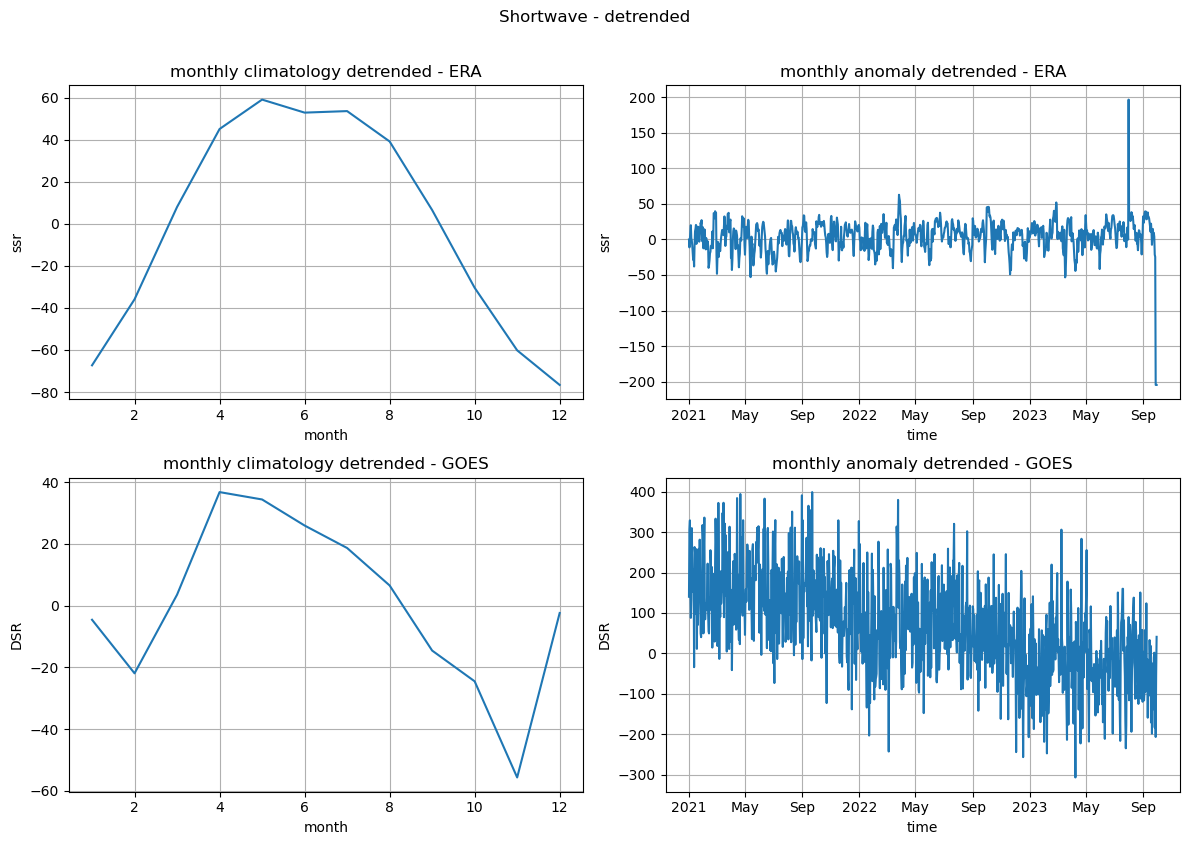

In [82]:
fig, ax = plt.subplots(2,2, figsize=(12,8))

mo_clim_sw_d.mean(['latitude', 'longitude']).plot(ax=ax[0,0])
ax[0,0].set_title('monthly climatology detrended - ERA')
ax[0,0].grid()
mo_anom_sw_d.sel(time=slice('2021', '2023-09-30')).mean(['latitude', 'longitude']).plot(ax=ax[0,1])
ax[0,1].set_title('monthly anomaly detrended - ERA')
ax[0,1].grid()

mo_clim_sw_d_g.mean(['lat', 'lon']).plot(ax=ax[1,0])
ax[1,0].set_title('monthly climatology detrended - GOES')
ax[1,0].grid()
mo_anom_sw_d_g.sel(time=slice('2021', '2023-09-30')).mean(['lat', 'lon']).plot(ax=ax[1,1])
ax[1,1].set_title('monthly anomaly detrended - GOES')
ax[1,1].grid()

plt.tight_layout()
plt.suptitle('Shortwave - detrended', y=1.05);

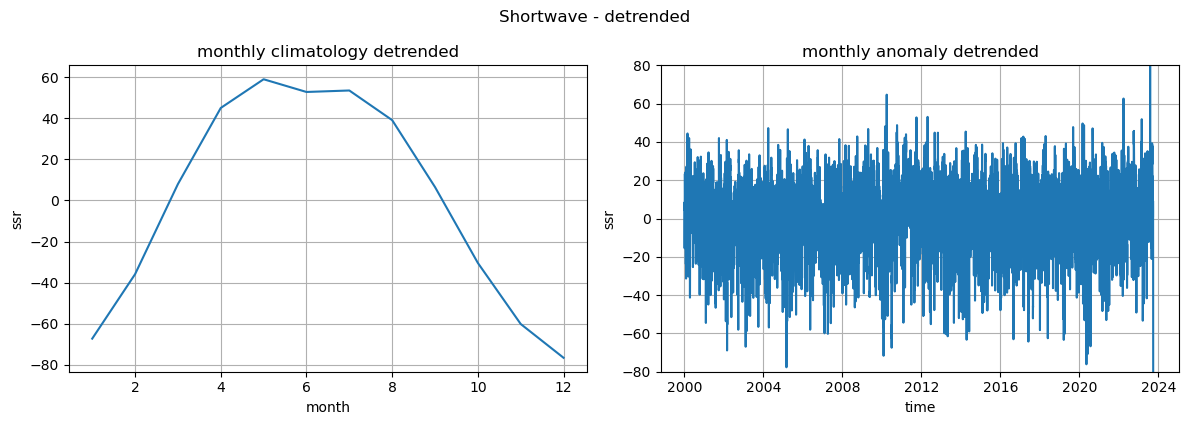

In [40]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

mo_clim_sw_d.mean(['latitude', 'longitude']).plot(ax=ax0)
ax0.set_title('monthly climatology detrended')
ax0.grid()
mo_anom_sw_d.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('monthly anomaly detrended')
ax1.grid()
ax1.set_ylim(-80,80)
plt.tight_layout()
plt.suptitle('Shortwave - detrended', y=1.05);

In [14]:
yr_clim_sw_d = sw_detrend_ufunc.groupby('time.year').mean(['time'])
yr_anom_sw_d = sw_detrend_ufunc.groupby('time.year') - yr_clim_sw_d

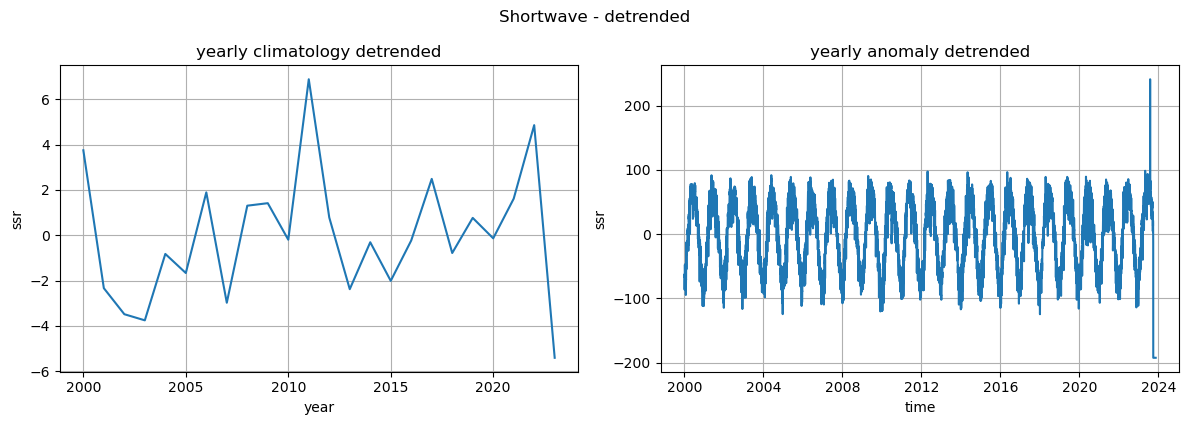

In [15]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

yr_clim_sw_d.mean(['latitude', 'longitude']).plot(ax=ax0)
ax0.set_title('yearly climatology detrended')
ax0.grid()
yr_anom_sw_d.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('yearly anomaly detrended')
ax1.grid()
plt.tight_layout()
plt.suptitle('Shortwave - detrended', y=1.05);

## SST

In [16]:
#convert to ˚C and resample to daily freq (hourly too noisy)
sst = (ds.sst-273.15).resample(time='D').mean('time')

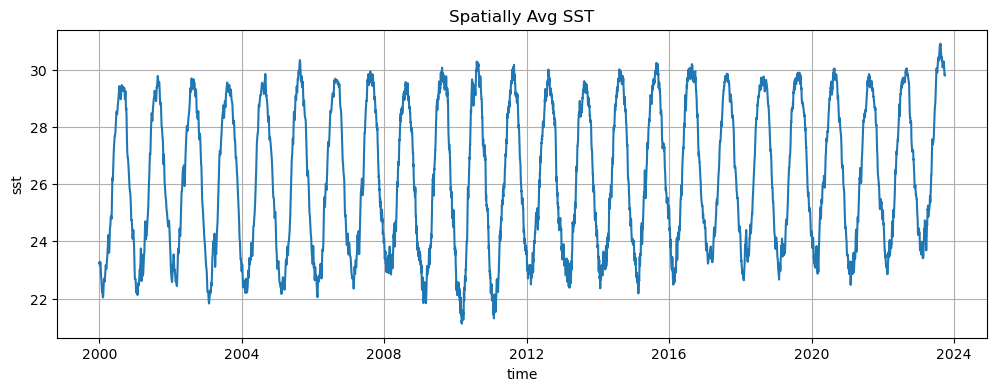

In [17]:
sst.mean(['latitude', 'longitude']).plot(figsize=(12,4))
plt.grid()
plt.title('Spatially Avg SST');

In [18]:
mo_clim_sst = sst.groupby('time.month').mean(['time', 'latitude', 'longitude'])
mo_anom_sst = sst.groupby('time.month') - mo_clim_sst

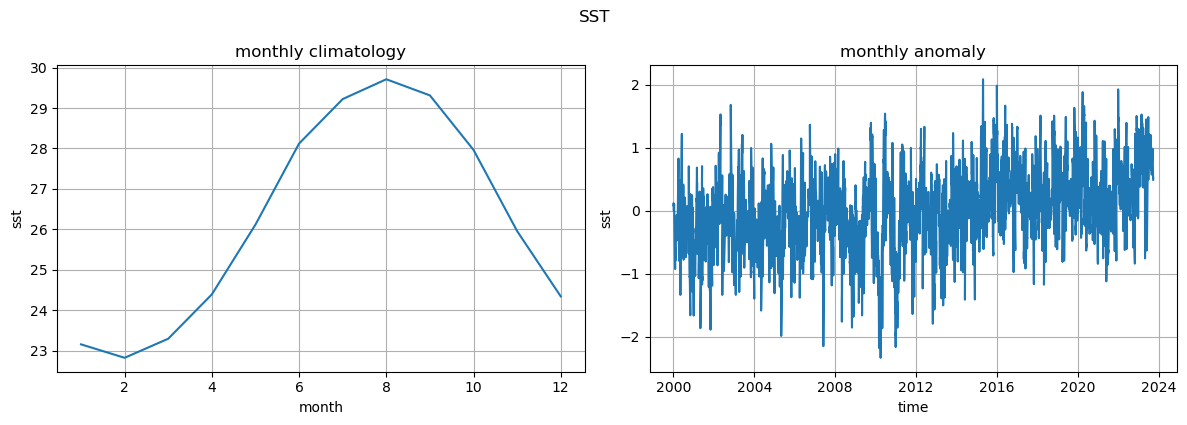

In [19]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

mo_clim_sst.plot(ax=ax0)
ax0.set_title('monthly climatology')
ax0.grid()
mo_anom_sst.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('monthly anomaly')
ax1.grid()
plt.tight_layout()
plt.suptitle('SST', y=1.05);

In [20]:
yr_clim_sst = sst.groupby('time.year').mean(['time', 'latitude', 'longitude'])
yr_anom_sst = sst.groupby('time.year') - yr_clim_sst

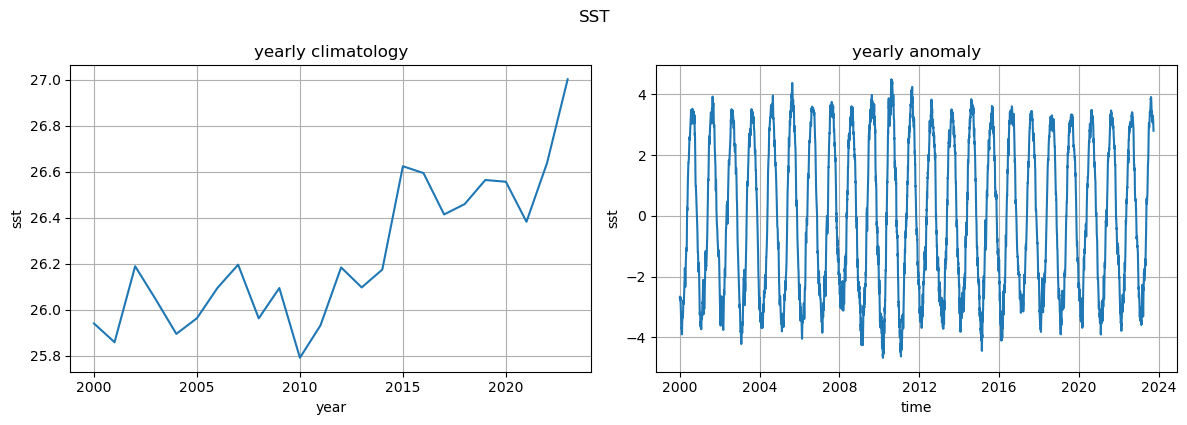

In [21]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

yr_clim_sst.plot(ax=ax0)
ax0.set_title('yearly climatology')
ax0.grid()
yr_anom_sst.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('yearly anomaly')
ax1.grid()
plt.tight_layout()
plt.suptitle('SST', y=1.05);

## Detrended SST

In [22]:
sst_detrend_ufunc = xr.apply_ufunc(detrend, sst.fillna(0.).chunk({'time':-1}), kwargs=dict(axis=-1),
                                   input_core_dims=[['time']],
                                   output_core_dims=[['time']],
                                   output_dtypes=[sst.dtype],
                                   dask='parallelized').reset_coords(drop=True)

In [23]:
sst_detrend_ufunc

<xarray.DataArray 'sst' (latitude: 37, longitude: 113, time: 8717)>
dask.array<transpose, shape=(37, 113, 8717), dtype=float32, chunksize=(37, 113, 8717), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 22.0 22.25 22.5 22.75 ... 30.5 30.75 31.0
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -72.5 -72.25 -72.0
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2023-11-12

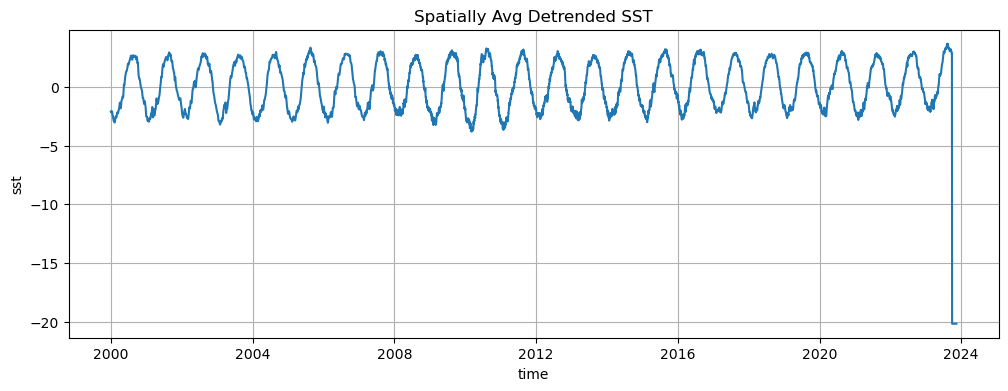

In [31]:
sst_detrend_ufunc.mean(['latitude', 'longitude']).plot(figsize=(12,4))
plt.grid()
plt.title('Spatially Avg Detrended SST');

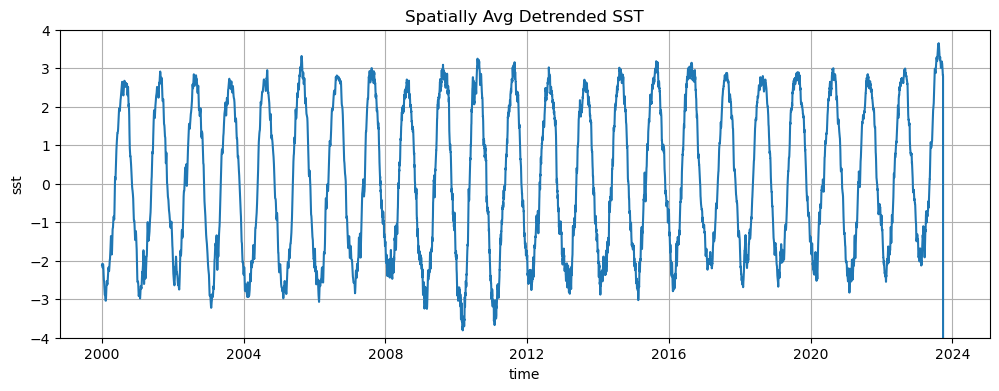

In [36]:
sst_detrend_ufunc.mean(['latitude', 'longitude']).plot(figsize=(12,4))
plt.grid()
plt.title('Spatially Avg Detrended SST')
plt.ylim(-4,4);

In [24]:
mo_clim_sst_d = sst_detrend_ufunc.groupby('time.month').mean(['time'])
mo_anom_sst_d = sst_detrend_ufunc.groupby('time.month') - mo_clim_sst_d

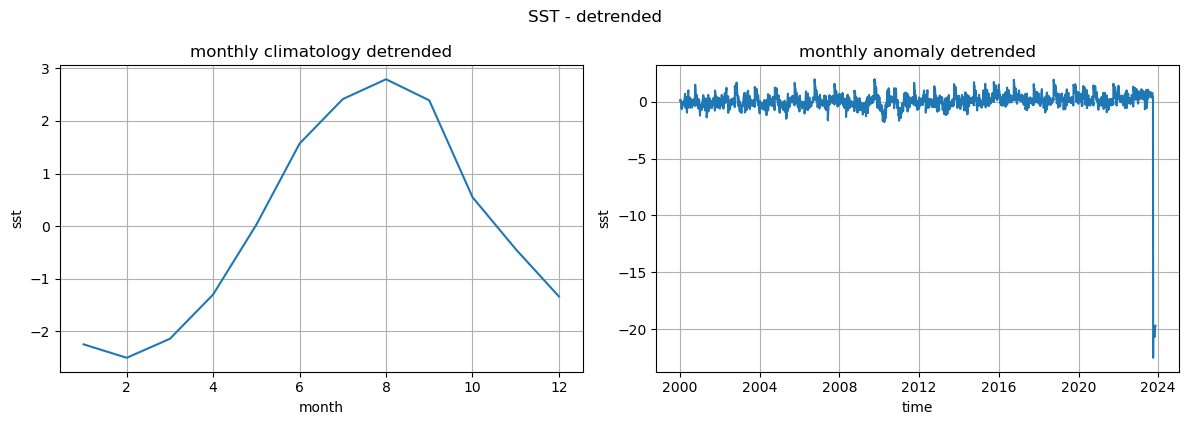

In [25]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

mo_clim_sst_d.mean(['latitude', 'longitude']).plot(ax=ax0)
ax0.set_title('monthly climatology detrended')
ax0.grid()
mo_anom_sst_d.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('monthly anomaly detrended')
ax1.grid()
plt.tight_layout()
plt.suptitle('SST - detrended', y=1.05);

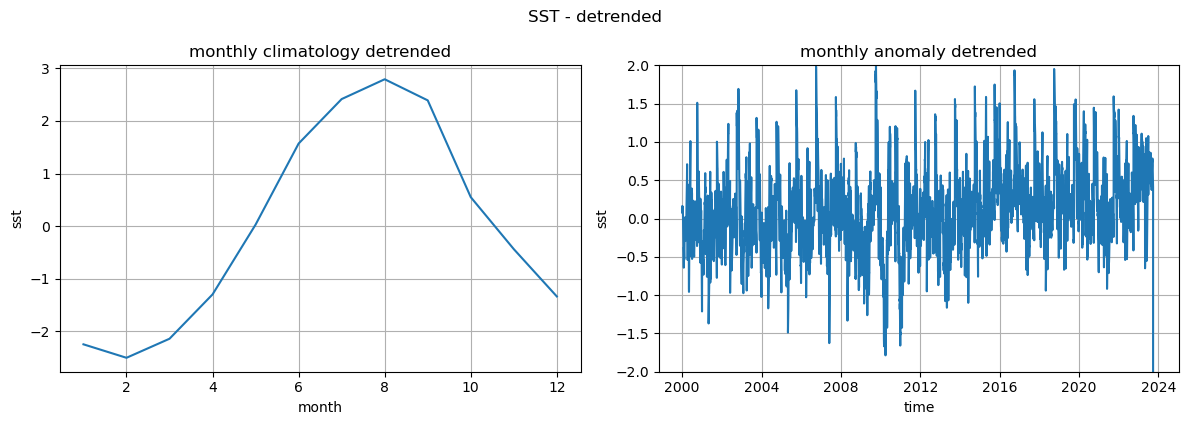

In [34]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

mo_clim_sst_d.mean(['latitude', 'longitude']).plot(ax=ax0)
ax0.set_title('monthly climatology detrended')
ax0.grid()
mo_anom_sst_d.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('monthly anomaly detrended')
ax1.grid()
ax1.set_ylim(-2, 2)
plt.tight_layout()
plt.suptitle('SST - detrended', y=1.05);

In [26]:
yr_clim_sst_d = sst_detrend_ufunc.groupby('time.year').mean(['time'])
yr_anom_sst_d = sst_detrend_ufunc.groupby('time.year') - yr_clim_sst_d

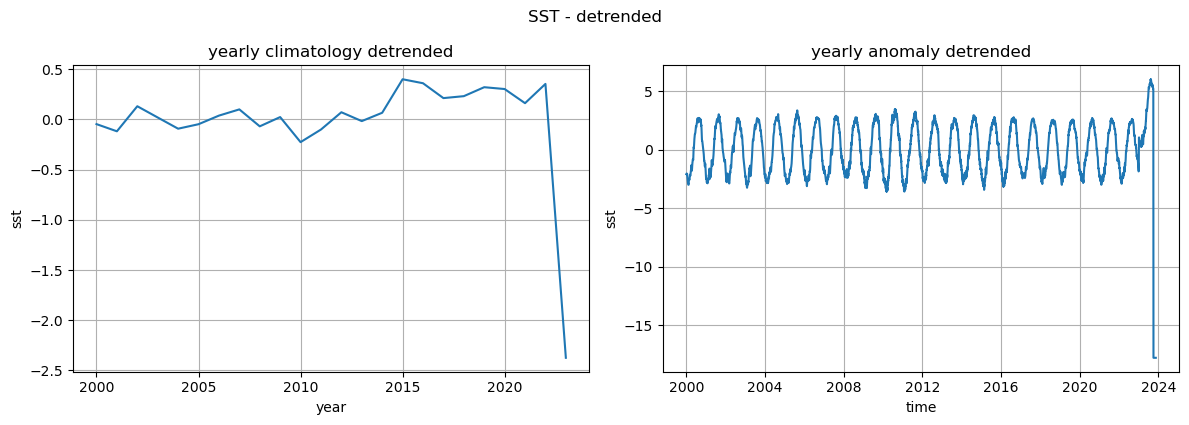

In [32]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

yr_clim_sst_d.mean(['latitude', 'longitude']).plot(ax=ax0)
ax0.set_title('yearly climatology detrended')
ax0.grid()
yr_anom_sst_d.mean(['latitude', 'longitude']).plot(ax=ax1)
ax1.set_title('yearly anomaly detrended')
ax1.grid()
plt.tight_layout()
plt.suptitle('SST - detrended', y=1.05);